In [55]:
# %% [markdown]
# ## 1. Chargement des Bibliothèques
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os
import keras.backend as K
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Reproductibilité
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [56]:
# %% [markdown]
# ## 2. Paramètres et Configuration
IMG_SIZE = (256, 256) 
BATCH_SIZE = 8
EPOCHS = 100
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1
DATA_PATH = '/home/kevin/datasets/livrable2/processed'

In [57]:
# %% [markdown]
# ## 3. Chargement et Préparation des Données (Version Corrigée)

def load_data(data_path):
    # Vérification hiérarchique renforcée
    noisy_path = os.path.join(data_path, 'noisy')
    clean_path = os.path.join(data_path, 'clean')
    
    for path in [noisy_path, clean_path]:
        if not os.path.isdir(path):
            raise ValueError(f"Dossier introuvable: {path}")
    
    # Collecte avec vérification d'extension
    valid_ext = ['.jpg', '.jpeg', '.png']
    
    noisy_files = sorted([f for f in os.listdir(noisy_path) 
                         if os.path.splitext(f)[1].lower() in valid_ext])
    clean_files = sorted([f for f in os.listdir(clean_path)
                         if os.path.splitext(f)[1].lower() in valid_ext])

    # Lecture avec progression et gestion d'erreur
    noisy_imgs, clean_imgs = [], []
    for idx, (nfile, cfile) in enumerate(zip(noisy_files, clean_files)):
        noisy_img = cv2.imread(os.path.join(noisy_path, nfile))
        noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_BGR2RGB)
        clean_img = cv2.imread(os.path.join(clean_path, cfile))
        clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)   
        
        if noisy_img is None:
            print(f"ERREUR: Échec de lecture de {nfile} (taille attendue: {IMG_SIZE})")
            continue
        if clean_img is None:
            print(f"ERREUR: Échec de lecture de {cfile} (taille attendue: {IMG_SIZE})")
            continue
        
        # Vérification de la taille
        if noisy_img.shape != (*IMG_SIZE, 3):
            print(f"Avertissement: {nfile} a une taille {noisy_img.shape}, ignoré")
            continue
            
        noisy_imgs.append(noisy_img)
        clean_imgs.append(clean_img)
        
        if (idx+1) % 10 == 0:
            print(f"Traité {idx+1}/{len(noisy_files)} paires")

    print(f"\nSuccès: {len(noisy_imgs)} paires valides sur {len(noisy_files)}")
    return np.array(noisy_imgs), np.array(clean_imgs)

# Chargement avec vérification
try:
    X_noisy, X_clean = load_data(DATA_PATH)
except Exception as e:
    print(f"Erreur: {e}")
    raise

# Vérification des dimensions
assert X_noisy.shape == X_clean.shape, "Dimensions incohérentes entre X_noisy et X_clean!"

# Normalisation [0,1]
X_noisy = X_noisy.astype('float32') / 255.0
X_clean = X_clean.astype('float32') / 255.0

# Split adaptatif pour petits datasets
TOTAL_SIZE = len(X_noisy)
print(f"Total d'images: {TOTAL_SIZE}")
if TOTAL_SIZE < 100:
    # Stratégie pour datasets réduits
    TEST_SPLIT = max(1, int(0.1 * TOTAL_SIZE))
    VAL_SPLIT = max(1, int(0.2 * TOTAL_SIZE))
else:
    TEST_SPLIT = 0.1
    VAL_SPLIT = 0.2

# Split avec shuffle stratifié
X_train, X_temp, y_train, y_temp = train_test_split(
    X_noisy, X_clean, 
    test_size=(VAL_SPLIT + TEST_SPLIT), 
    random_state=SEED,
    shuffle=True
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=TEST_SPLIT/(VAL_SPLIT + TEST_SPLIT), 
    random_state=SEED
)

print(f"\nSplit Final:")
print(f"- Train: {len(X_train)}")
print(f"- Val: {len(X_val)}")
print(f"- Test: {len(X_test)}")

Traité 10/298 paires
Traité 20/298 paires
Traité 30/298 paires
Traité 40/298 paires
Traité 50/298 paires
Traité 60/298 paires
Traité 70/298 paires
Traité 80/298 paires
Traité 90/298 paires
Traité 100/298 paires
Traité 110/298 paires
Traité 120/298 paires
Traité 130/298 paires
Traité 140/298 paires
Traité 150/298 paires
Traité 160/298 paires
Traité 170/298 paires
Traité 180/298 paires
Traité 190/298 paires
Traité 200/298 paires
Traité 210/298 paires
Traité 220/298 paires
Traité 230/298 paires
Traité 240/298 paires
Traité 250/298 paires
Traité 260/298 paires
Traité 270/298 paires
Traité 280/298 paires
Traité 290/298 paires

Succès: 298 paires valides sur 298
Total d'images: 298

Split Final:
- Train: 208
- Val: 60
- Test: 30


In [58]:
class SpatialAttention(layers.Layer):
    def __init__(self, ratio=8, **kwargs):
        super(SpatialAttention, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channels = input_shape[-1]
        self.dense1 = layers.Dense(channels // self.ratio, activation='relu', 
                                  kernel_initializer='he_normal', use_bias=False)
        self.dense2 = layers.Dense(channels, activation='sigmoid', 
                                  kernel_initializer='he_normal', use_bias=False)
        self.conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')
        super(SpatialAttention, self).build(input_shape)

    def call(self, x):
        channels = x.shape[-1]
        
        # Channel attention branch
        avg_pool = layers.GlobalAveragePooling2D()(x)
        avg_pool = layers.Reshape((1, 1, channels))(avg_pool)
        avg_pool = self.dense1(avg_pool)
        avg_pool = self.dense2(avg_pool)
        
        # Spatial attention branch
        # Use tf.reduce_max instead of K.max
        max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(x)
        # Use tf.reduce_mean instead of K.mean
        avg_pool_spatial = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(x)
        concat = layers.Concatenate()([max_pool, avg_pool_spatial])
        spatial = self.conv(concat)
        
        # Apply attention
        return x * avg_pool * spatial

def ResidualConvBlock(x, filters):
    """
    Creates a residual convolutional block.
    
    Args:
        x: Input tensor
        filters: Number of filters in the convolutional layers
        
    Returns:
        A tensor after applying residual convolutions
    """
    shortcut = x
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, 3, padding='same')(x)
    x = layers.Add()([shortcut, x])
    return x

def improved_unet(input_shape=(256,256,3)):
    """
    Creates an improved U-Net model with residual blocks and skip connections.
    
    Args:
        input_shape: Input shape of the images (height, width, channels)
        
    Returns:
        A compiled Keras model
    """
    inputs = layers.Input(input_shape)
    
    # Encoder with residual blocks
    e1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    e1 = ResidualConvBlock(e1, 64)
    p1 = layers.MaxPooling2D()(e1)
    
    e2 = layers.Conv2D(128, 3, activation='relu', padding='same')(p1)
    e2 = ResidualConvBlock(e2, 128)
    p2 = layers.MaxPooling2D()(e2)
    
    # Bottleneck with attention and dropout
    bridge = layers.Conv2D(256, 3, activation='relu', padding='same')(p2)
    bridge = SpatialAttention()(bridge)
    bridge = layers.Dropout(0.3)(bridge)
    
    # Decoder with skip connections
    d1 = layers.UpSampling2D()(bridge)
    d1 = layers.Concatenate()([d1, e2])
    d1 = layers.Conv2D(128, 3, activation='relu', padding='same')(d1)
    
    d2 = layers.UpSampling2D()(d1)
    d2 = layers.Concatenate()([d2, e1])
    d2 = layers.Conv2D(64, 3, activation='relu', padding='same')(d2)
    
    outputs = layers.Conv2D(3, 1, activation='sigmoid')(d2)
    
    return Model(inputs, outputs)

In [59]:
# %% [markdown]
# ## 5. Métriques Personnalisées + Callbacks Learning rate et TensorBoard
import datetime


def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

def SSIM(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, max_val=1.0)

vgg = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(256,256,3))
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)
loss_model.trainable = False

def hybrid_loss(y_true, y_pred):
    # Perte structurelle (déjà un scalaire)
    ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
    
    # Perte de contenu (réduction explicite)
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Perte perceptuelle (prétraitement VGG16)
    
    y_true_features = loss_model(y_true)
    y_pred_features = loss_model(y_pred)
    
    # Réduction explicite de la perte perceptuelle
    perceptual_loss = tf.reduce_mean(tf.square(y_true_features - y_pred_features))
    
    # Maintenant toutes les pertes sont des scalaires et peuvent être additionnées
    return 0.6*ssim_loss + 0.3*mse_loss + 0.1*perceptual_loss

class WarmUpAndCosineDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, base_lr, warmup_steps, total_steps, min_lr=1e-6):
        super().__init__()
        self.base_lr = base_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        progress = (step - self.warmup_steps) / tf.maximum(1.0, self.total_steps - self.warmup_steps)
        progress = tf.clip_by_value(progress, 0.0, 1.0)
        cosine_decay = 0.5 * (1 + tf.cos(np.pi * progress))
        decayed_lr = (self.base_lr - self.min_lr) * cosine_decay + self.min_lr

        lr = tf.cond(
            step < self.warmup_steps,
            lambda: self.base_lr * (step / self.warmup_steps),
            lambda: decayed_lr
        )
        return lr

    def get_config(self):
        return {
            "base_lr": self.base_lr,
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps,
            "min_lr": self.min_lr
        }

    
class LearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        if callable(lr):
            lr = lr(self.model.optimizer.iterations)
        print(f"\n📉 [Epoch {epoch+1}] Current Learning Rate: {lr:.6f}")



log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=0
)

In [60]:
# %% [markdown]
# ## 6. Compilation et Entraînement
model = improved_unet()
initial_learning_rate = 1e-3
steps_per_epoch = len(X_train) // BATCH_SIZE
total_steps = EPOCHS * steps_per_epoch

lr_schedule = WarmUpAndCosineDecay(
    base_lr=1e-3,
    warmup_steps=5 * steps_per_epoch,
    total_steps=total_steps,
    min_lr=1e-6
)

optimizer = tf.keras.optimizers.AdamW(
    learning_rate=lr_schedule,
    weight_decay=1e-4
)
model.compile(
    optimizer=optimizer,
    loss=hybrid_loss,
    metrics=[PSNR, SSIM]
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor='val_loss',
    save_weights_only=False,
    verbose=1
)

lr_logger = LearningRateLogger()

######## tensorboard --logdir=logs/fit


## Entraînement avec validation
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        early_stop,
        checkpoint,
        tensorboard_cb,
        lr_logger
    ],
    verbose=1
)

Epoch 1/100


2025-04-16 10:41:18.411785: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_1', 232 bytes spill stores, 232 bytes spill loads



26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 5.2812 - psnr: 9.6580 - ssim: 0.1144
Epoch 1: val_loss improved from inf to 5.01384, saving model to best_model.h5



📉 [Epoch 1] Current Learning Rate: 0.000200
26/26 ━━━━━━━━━━━━━━━━━━━━ 33s 410ms/step - loss: 5.2657 - psnr: 9.6507 - ssim: 0.1160 - val_loss: 5.0138 - val_psnr: 11.1594 - val_ssim: 0.3492
Epoch 2/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 4.0621 - psnr: 9.9577 - ssim: 0.2520
Epoch 2: val_loss improved from 5.01384 to 4.92740, saving model to best_model.h5



📉 [Epoch 2] Current Learning Rate: 0.000400
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 4.0540 - psnr: 9.9896 - ssim: 0.2533 - val_loss: 4.9274 - val_psnr: 11.6248 - val_ssim: 0.3775
Epoch 3/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 3.4072 - psnr: 12.9109 - ssim: 0.3724
Epoch 3: val_loss improved from 4.92740 to 4.83205, saving model to best_model.h5



📉 [Epoch 3] Current Learning Rate: 0.000600
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 241ms/step - loss: 3.4034 - psnr: 12.9176 - ssim: 0.3731 - val_loss: 4.8320 - val_psnr: 11.9429 - val_ssim: 0.3904
Epoch 4/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 3.1594 - psnr: 14.3740 - ssim: 0.4359
Epoch 4: val_loss improved from 4.83205 to 4.76022, saving model to best_model.h5



📉 [Epoch 4] Current Learning Rate: 0.000800
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 238ms/step - loss: 3.1566 - psnr: 14.3722 - ssim: 0.4363 - val_loss: 4.7602 - val_psnr: 12.2265 - val_ssim: 0.3986
Epoch 5/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 2.8063 - psnr: 15.7077 - ssim: 0.4935
Epoch 5: val_loss did not improve from 4.76022

📉 [Epoch 5] Current Learning Rate: 0.001000
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - loss: 2.8002 - psnr: 15.7149 - ssim: 0.4942 - val_loss: 4.7861 - val_psnr: 11.9595 - val_ssim: 0.3815
Epoch 6/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 2.2945 - psnr: 17.5932 - ssim: 0.5583
Epoch 6: val_loss improved from 4.76022 to 4.67736, saving model to best_model.h5



📉 [Epoch 6] Current Learning Rate: 0.001000
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 249ms/step - loss: 2.2904 - psnr: 17.6028 - ssim: 0.5588 - val_loss: 4.6774 - val_psnr: 11.8442 - val_ssim: 0.3726
Epoch 7/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 1.9459 - psnr: 19.3122 - ssim: 0.6117
Epoch 7: val_loss did not improve from 4.67736

📉 [Epoch 7] Current Learning Rate: 0.000999
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - loss: 1.9420 - psnr: 19.3091 - ssim: 0.6122 - val_loss: 4.7111 - val_psnr: 11.9991 - val_ssim: 0.3923
Epoch 8/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 1.6983 - psnr: 20.2075 - ssim: 0.6455
Epoch 8: val_loss improved from 4.67736 to 4.53884, saving model to best_model.h5



📉 [Epoch 8] Current Learning Rate: 0.000998
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 1.6961 - psnr: 20.2112 - ssim: 0.6459 - val_loss: 4.5388 - val_psnr: 12.2616 - val_ssim: 0.4104
Epoch 9/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 1.5719 - psnr: 21.3016 - ssim: 0.6655
Epoch 9: val_loss improved from 4.53884 to 4.33327, saving model to best_model.h5



📉 [Epoch 9] Current Learning Rate: 0.000996
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 1.5703 - psnr: 21.3008 - ssim: 0.6657 - val_loss: 4.3333 - val_psnr: 12.3294 - val_ssim: 0.4282
Epoch 10/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1.5057 - psnr: 21.6356 - ssim: 0.6789
Epoch 10: val_loss improved from 4.33327 to 3.99930, saving model to best_model.h5



📉 [Epoch 10] Current Learning Rate: 0.000993
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 1.5037 - psnr: 21.6332 - ssim: 0.6792 - val_loss: 3.9993 - val_psnr: 12.8886 - val_ssim: 0.4489
Epoch 11/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1.4086 - psnr: 22.2563 - ssim: 0.6944
Epoch 11: val_loss improved from 3.99930 to 3.64051, saving model to best_model.h5



📉 [Epoch 11] Current Learning Rate: 0.000990
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 231ms/step - loss: 1.4068 - psnr: 22.2518 - ssim: 0.6946 - val_loss: 3.6405 - val_psnr: 13.2261 - val_ssim: 0.4662
Epoch 12/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1.3495 - psnr: 22.4730 - ssim: 0.7024
Epoch 12: val_loss improved from 3.64051 to 3.37861, saving model to best_model.h5



📉 [Epoch 12] Current Learning Rate: 0.000987
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 1.3475 - psnr: 22.4715 - ssim: 0.7027 - val_loss: 3.3786 - val_psnr: 13.5613 - val_ssim: 0.4798
Epoch 13/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1.2894 - psnr: 22.8769 - ssim: 0.7106
Epoch 13: val_loss improved from 3.37861 to 3.11446, saving model to best_model.h5



📉 [Epoch 13] Current Learning Rate: 0.000983
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 1.2876 - psnr: 22.8720 - ssim: 0.7109 - val_loss: 3.1145 - val_psnr: 14.0660 - val_ssim: 0.4969
Epoch 14/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 1.2459 - psnr: 23.0946 - ssim: 0.7182
Epoch 14: val_loss improved from 3.11446 to 2.86946, saving model to best_model.h5



📉 [Epoch 14] Current Learning Rate: 0.000978
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 1.2443 - psnr: 23.0884 - ssim: 0.7185 - val_loss: 2.8695 - val_psnr: 14.6383 - val_ssim: 0.5140
Epoch 15/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1.2250 - psnr: 23.3043 - ssim: 0.7224
Epoch 15: val_loss improved from 2.86946 to 2.48315, saving model to best_model.h5



📉 [Epoch 15] Current Learning Rate: 0.000973
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 1.2233 - psnr: 23.2976 - ssim: 0.7228 - val_loss: 2.4832 - val_psnr: 15.3844 - val_ssim: 0.5426
Epoch 16/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 1.1686 - psnr: 23.5406 - ssim: 0.7316
Epoch 16: val_loss improved from 2.48315 to 2.36351, saving model to best_model.h5



📉 [Epoch 16] Current Learning Rate: 0.000967
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - loss: 1.1670 - psnr: 23.5390 - ssim: 0.7319 - val_loss: 2.3635 - val_psnr: 16.1511 - val_ssim: 0.5576
Epoch 17/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 1.1120 - psnr: 23.4142 - ssim: 0.7374
Epoch 17: val_loss improved from 2.36351 to 2.12917, saving model to best_model.h5



📉 [Epoch 17] Current Learning Rate: 0.000961
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - loss: 1.1104 - psnr: 23.4193 - ssim: 0.7378 - val_loss: 2.1292 - val_psnr: 16.8817 - val_ssim: 0.5793
Epoch 18/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 1.0684 - psnr: 23.7433 - ssim: 0.7455
Epoch 18: val_loss improved from 2.12917 to 1.88132, saving model to best_model.h5



📉 [Epoch 18] Current Learning Rate: 0.000955
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - loss: 1.0670 - psnr: 23.7432 - ssim: 0.7458 - val_loss: 1.8813 - val_psnr: 18.1363 - val_ssim: 0.6105
Epoch 19/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 1.0194 - psnr: 23.9418 - ssim: 0.7535
Epoch 19: val_loss improved from 1.88132 to 1.57518, saving model to best_model.h5



📉 [Epoch 19] Current Learning Rate: 0.000947
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - loss: 1.0181 - psnr: 23.9401 - ssim: 0.7538 - val_loss: 1.5752 - val_psnr: 19.8848 - val_ssim: 0.6550
Epoch 20/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.9917 - psnr: 24.0078 - ssim: 0.7582
Epoch 20: val_loss improved from 1.57518 to 1.32892, saving model to best_model.h5



📉 [Epoch 20] Current Learning Rate: 0.000940
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - loss: 0.9906 - psnr: 24.0038 - ssim: 0.7584 - val_loss: 1.3289 - val_psnr: 21.7616 - val_ssim: 0.7023
Epoch 21/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.9658 - psnr: 24.1310 - ssim: 0.7627
Epoch 21: val_loss improved from 1.32892 to 1.12243, saving model to best_model.h5



📉 [Epoch 21] Current Learning Rate: 0.000932
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - loss: 0.9647 - psnr: 24.1259 - ssim: 0.7629 - val_loss: 1.1224 - val_psnr: 23.3938 - val_ssim: 0.7460
Epoch 22/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - loss: 0.9616 - psnr: 24.2023 - ssim: 0.7646
Epoch 22: val_loss improved from 1.12243 to 1.05520, saving model to best_model.h5



📉 [Epoch 22] Current Learning Rate: 0.000923
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - loss: 0.9602 - psnr: 24.1970 - ssim: 0.7649 - val_loss: 1.0552 - val_psnr: 23.3034 - val_ssim: 0.7481
Epoch 23/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.9521 - psnr: 24.3058 - ssim: 0.7654
Epoch 23: val_loss did not improve from 1.05520

📉 [Epoch 23] Current Learning Rate: 0.000914
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - loss: 0.9507 - psnr: 24.3017 - ssim: 0.7658 - val_loss: 1.0633 - val_psnr: 22.3313 - val_ssim: 0.7432
Epoch 24/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.9215 - psnr: 24.3704 - ssim: 0.7681
Epoch 24: val_loss improved from 1.05520 to 0.97075, saving model to best_model.h5



📉 [Epoch 24] Current Learning Rate: 0.000905
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 230ms/step - loss: 0.9203 - psnr: 24.3691 - ssim: 0.7684 - val_loss: 0.9708 - val_psnr: 23.3537 - val_ssim: 0.7566
Epoch 25/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.8790 - psnr: 24.5293 - ssim: 0.7749
Epoch 25: val_loss improved from 0.97075 to 0.94001, saving model to best_model.h5



📉 [Epoch 25] Current Learning Rate: 0.000895
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - loss: 0.8781 - psnr: 24.5299 - ssim: 0.7752 - val_loss: 0.9400 - val_psnr: 24.5239 - val_ssim: 0.7687
Epoch 26/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.8699 - psnr: 24.4152 - ssim: 0.7750
Epoch 26: val_loss improved from 0.94001 to 0.93237, saving model to best_model.h5



📉 [Epoch 26] Current Learning Rate: 0.000884
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - loss: 0.8690 - psnr: 24.4156 - ssim: 0.7753 - val_loss: 0.9324 - val_psnr: 25.2420 - val_ssim: 0.7729
Epoch 27/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.8626 - psnr: 24.4147 - ssim: 0.7770
Epoch 27: val_loss improved from 0.93237 to 0.89596, saving model to best_model.h5



📉 [Epoch 27] Current Learning Rate: 0.000874
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 228ms/step - loss: 0.8614 - psnr: 24.4146 - ssim: 0.7773 - val_loss: 0.8960 - val_psnr: 25.7956 - val_ssim: 0.7784
Epoch 28/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.8327 - psnr: 24.7143 - ssim: 0.7832
Epoch 28: val_loss improved from 0.89596 to 0.88034, saving model to best_model.h5



📉 [Epoch 28] Current Learning Rate: 0.000862
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - loss: 0.8318 - psnr: 24.7084 - ssim: 0.7835 - val_loss: 0.8803 - val_psnr: 25.5324 - val_ssim: 0.7783
Epoch 29/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.8103 - psnr: 24.9372 - ssim: 0.7868
Epoch 29: val_loss improved from 0.88034 to 0.85195, saving model to best_model.h5



📉 [Epoch 29] Current Learning Rate: 0.000851
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - loss: 0.8094 - psnr: 24.9337 - ssim: 0.7871 - val_loss: 0.8519 - val_psnr: 25.5798 - val_ssim: 0.7841
Epoch 30/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.7955 - psnr: 25.0108 - ssim: 0.7897
Epoch 30: val_loss improved from 0.85195 to 0.84212, saving model to best_model.h5



📉 [Epoch 30] Current Learning Rate: 0.000839
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - loss: 0.7947 - psnr: 25.0102 - ssim: 0.7899 - val_loss: 0.8421 - val_psnr: 25.7951 - val_ssim: 0.7896
Epoch 31/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.7848 - psnr: 24.9570 - ssim: 0.7917
Epoch 31: val_loss did not improve from 0.84212

📉 [Epoch 31] Current Learning Rate: 0.000826
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - loss: 0.7839 - psnr: 24.9557 - ssim: 0.7920 - val_loss: 0.8609 - val_psnr: 25.5283 - val_ssim: 0.7822
Epoch 32/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.7808 - psnr: 25.0154 - ssim: 0.7914
Epoch 32: val_loss did not improve from 0.84212

📉 [Epoch 32] Current Learning Rate: 0.000814
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - loss: 0.7798 - psnr: 25.0137 - ssim: 0.7917 - val_loss: 0.8525 - val_psnr: 26.2584 - val_ssim: 0.7879
Epoch 33/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.7737 - psnr: 25.0476 - ssim: 0.7934
Epoch 33: val_loss improved fro


📉 [Epoch 33] Current Learning Rate: 0.000801
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - loss: 0.7728 - psnr: 25.0478 - ssim: 0.7937 - val_loss: 0.8228 - val_psnr: 26.4706 - val_ssim: 0.7945
Epoch 34/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.7641 - psnr: 25.0117 - ssim: 0.7955
Epoch 34: val_loss did not improve from 0.82280

📉 [Epoch 34] Current Learning Rate: 0.000787
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - loss: 0.7633 - psnr: 25.0076 - ssim: 0.7958 - val_loss: 0.8690 - val_psnr: 24.6621 - val_ssim: 0.7822
Epoch 35/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.7621 - psnr: 24.7470 - ssim: 0.7945
Epoch 35: val_loss did not improve from 0.82280

📉 [Epoch 35] Current Learning Rate: 0.000774
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - loss: 0.7611 - psnr: 24.7431 - ssim: 0.7948 - val_loss: 0.8644 - val_psnr: 24.7419 - val_ssim: 0.7867
Epoch 36/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.7550 - psnr: 24.8297 - ssim: 0.7949
Epoch 36: val_loss did not impr


📉 [Epoch 37] Current Learning Rate: 0.000745
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - loss: 0.7372 - psnr: 25.0899 - ssim: 0.7975 - val_loss: 0.8086 - val_psnr: 25.1529 - val_ssim: 0.7971
Epoch 38/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.7202 - psnr: 25.1626 - ssim: 0.7991
Epoch 38: val_loss did not improve from 0.80856

📉 [Epoch 38] Current Learning Rate: 0.000731
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - loss: 0.7195 - psnr: 25.1584 - ssim: 0.7993 - val_loss: 0.8625 - val_psnr: 24.2961 - val_ssim: 0.7883
Epoch 39/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.7191 - psnr: 25.2043 - ssim: 0.7994
Epoch 39: val_loss did not improve from 0.80856

📉 [Epoch 39] Current Learning Rate: 0.000716
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - loss: 0.7186 - psnr: 25.2020 - ssim: 0.7996 - val_loss: 0.8655 - val_psnr: 24.8565 - val_ssim: 0.7847
Epoch 40/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.7316 - psnr: 24.9564 - ssim: 0.7984
Epoch 40: val_loss did not impr


📉 [Epoch 46] Current Learning Rate: 0.000607
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - loss: 0.6792 - psnr: 25.3749 - ssim: 0.8067 - val_loss: 0.7806 - val_psnr: 26.6646 - val_ssim: 0.8077
Epoch 47/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.6777 - psnr: 25.2691 - ssim: 0.8071
Epoch 47: val_loss did not improve from 0.78056

📉 [Epoch 47] Current Learning Rate: 0.000591
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - loss: 0.6769 - psnr: 25.2702 - ssim: 0.8073 - val_loss: 0.7830 - val_psnr: 26.7910 - val_ssim: 0.8095
Epoch 48/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.6681 - psnr: 25.5266 - ssim: 0.8103
Epoch 48: val_loss did not improve from 0.78056

📉 [Epoch 48] Current Learning Rate: 0.000575
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - loss: 0.6673 - psnr: 25.5266 - ssim: 0.8105 - val_loss: 0.7964 - val_psnr: 26.7125 - val_ssim: 0.8005
Epoch 49/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.6592 - psnr: 25.5002 - ssim: 0.8107
Epoch 49: val_loss improved fro


📉 [Epoch 49] Current Learning Rate: 0.000558
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - loss: 0.6583 - psnr: 25.4986 - ssim: 0.8109 - val_loss: 0.7656 - val_psnr: 26.7752 - val_ssim: 0.8035
Epoch 50/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.6465 - psnr: 25.5787 - ssim: 0.8123
Epoch 50: val_loss improved from 0.76564 to 0.74270, saving model to best_model.h5



📉 [Epoch 50] Current Learning Rate: 0.000542
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - loss: 0.6456 - psnr: 25.5760 - ssim: 0.8126 - val_loss: 0.7427 - val_psnr: 27.0049 - val_ssim: 0.8072
Epoch 51/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.6294 - psnr: 25.6392 - ssim: 0.8141
Epoch 51: val_loss did not improve from 0.74270

📉 [Epoch 51] Current Learning Rate: 0.000525
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - loss: 0.6287 - psnr: 25.6361 - ssim: 0.8143 - val_loss: 0.7436 - val_psnr: 26.9127 - val_ssim: 0.8103
Epoch 52/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.6212 - psnr: 25.7145 - ssim: 0.8153
Epoch 52: val_loss did not improve from 0.74270

📉 [Epoch 52] Current Learning Rate: 0.000509
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - loss: 0.6205 - psnr: 25.7128 - ssim: 0.8155 - val_loss: 0.7449 - val_psnr: 26.9668 - val_ssim: 0.8122
Epoch 53/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.6168 - psnr: 25.8022 - ssim: 0.8157
Epoch 53: val_loss did not impr


📉 [Epoch 54] Current Learning Rate: 0.000476
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - loss: 0.6147 - psnr: 25.7843 - ssim: 0.8158 - val_loss: 0.7351 - val_psnr: 26.7807 - val_ssim: 0.8117
Epoch 55/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.6092 - psnr: 25.7226 - ssim: 0.8162
Epoch 55: val_loss improved from 0.73507 to 0.72852, saving model to best_model.h5



📉 [Epoch 55] Current Learning Rate: 0.000459
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - loss: 0.6086 - psnr: 25.7249 - ssim: 0.8165 - val_loss: 0.7285 - val_psnr: 26.8581 - val_ssim: 0.8145
Epoch 56/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.6088 - psnr: 25.6872 - ssim: 0.8161
Epoch 56: val_loss did not improve from 0.72852

📉 [Epoch 56] Current Learning Rate: 0.000443
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - loss: 0.6082 - psnr: 25.6912 - ssim: 0.8163 - val_loss: 0.7457 - val_psnr: 26.7272 - val_ssim: 0.8134
Epoch 57/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.6129 - psnr: 25.7469 - ssim: 0.8159
Epoch 57: val_loss did not improve from 0.72852

📉 [Epoch 57] Current Learning Rate: 0.000426
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 214ms/step - loss: 0.6122 - psnr: 25.7495 - ssim: 0.8162 - val_loss: 0.7454 - val_psnr: 26.6994 - val_ssim: 0.8121
Epoch 58/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.6095 - psnr: 25.8432 - ssim: 0.8165
Epoch 58: val_loss did not impr


📉 [Epoch 65] Current Learning Rate: 0.000300
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - loss: 0.5800 - psnr: 25.9818 - ssim: 0.8224 - val_loss: 0.7177 - val_psnr: 26.1591 - val_ssim: 0.8162
Epoch 66/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5740 - psnr: 26.0184 - ssim: 0.8227
Epoch 66: val_loss improved from 0.71771 to 0.69756, saving model to best_model.h5



📉 [Epoch 66] Current Learning Rate: 0.000285
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - loss: 0.5734 - psnr: 26.0123 - ssim: 0.8229 - val_loss: 0.6976 - val_psnr: 26.6999 - val_ssim: 0.8180
Epoch 67/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5739 - psnr: 26.0422 - ssim: 0.8225
Epoch 67: val_loss improved from 0.69756 to 0.67756, saving model to best_model.h5



📉 [Epoch 67] Current Learning Rate: 0.000270
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - loss: 0.5734 - psnr: 26.0361 - ssim: 0.8227 - val_loss: 0.6776 - val_psnr: 27.1603 - val_ssim: 0.8174
Epoch 68/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.5686 - psnr: 26.0934 - ssim: 0.8219
Epoch 68: val_loss did not improve from 0.67756

📉 [Epoch 68] Current Learning Rate: 0.000256
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - loss: 0.5681 - psnr: 26.0879 - ssim: 0.8221 - val_loss: 0.6815 - val_psnr: 26.8333 - val_ssim: 0.8166
Epoch 69/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.5601 - psnr: 26.1554 - ssim: 0.8227
Epoch 69: val_loss did not improve from 0.67756

📉 [Epoch 69] Current Learning Rate: 0.000241
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - loss: 0.5595 - psnr: 26.1513 - ssim: 0.8230 - val_loss: 0.6793 - val_psnr: 27.0222 - val_ssim: 0.8200
Epoch 70/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5555 - psnr: 26.1418 - ssim: 0.8237
Epoch 70: val_loss improved fro


📉 [Epoch 70] Current Learning Rate: 0.000227
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - loss: 0.5550 - psnr: 26.1382 - ssim: 0.8240 - val_loss: 0.6739 - val_psnr: 27.0768 - val_ssim: 0.8225
Epoch 71/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5550 - psnr: 26.1584 - ssim: 0.8244
Epoch 71: val_loss did not improve from 0.67391

📉 [Epoch 71] Current Learning Rate: 0.000214
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - loss: 0.5545 - psnr: 26.1541 - ssim: 0.8246 - val_loss: 0.6759 - val_psnr: 26.9647 - val_ssim: 0.8228
Epoch 72/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5541 - psnr: 26.1751 - ssim: 0.8245
Epoch 72: val_loss did not improve from 0.67391

📉 [Epoch 72] Current Learning Rate: 0.000200
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - loss: 0.5536 - psnr: 26.1693 - ssim: 0.8247 - val_loss: 0.6811 - val_psnr: 26.9105 - val_ssim: 0.8235
Epoch 73/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5494 - psnr: 26.2045 - ssim: 0.8253
Epoch 73: val_loss did not impr


📉 [Epoch 74] Current Learning Rate: 0.000175
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - loss: 0.5439 - psnr: 26.2475 - ssim: 0.8263 - val_loss: 0.6708 - val_psnr: 26.9762 - val_ssim: 0.8244
Epoch 75/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.5391 - psnr: 26.2957 - ssim: 0.8268
Epoch 75: val_loss improved from 0.67079 to 0.66658, saving model to best_model.h5



📉 [Epoch 75] Current Learning Rate: 0.000162
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - loss: 0.5385 - psnr: 26.2890 - ssim: 0.8270 - val_loss: 0.6666 - val_psnr: 26.8762 - val_ssim: 0.8237
Epoch 76/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5322 - psnr: 26.3084 - ssim: 0.8274
Epoch 76: val_loss improved from 0.66658 to 0.66271, saving model to best_model.h5



📉 [Epoch 76] Current Learning Rate: 0.000150
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - loss: 0.5317 - psnr: 26.3021 - ssim: 0.8276 - val_loss: 0.6627 - val_psnr: 26.6900 - val_ssim: 0.8227
Epoch 77/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.5288 - psnr: 26.2953 - ssim: 0.8274
Epoch 77: val_loss did not improve from 0.66271

📉 [Epoch 77] Current Learning Rate: 0.000139
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - loss: 0.5282 - psnr: 26.2903 - ssim: 0.8276 - val_loss: 0.6628 - val_psnr: 26.4965 - val_ssim: 0.8227
Epoch 78/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5262 - psnr: 26.3068 - ssim: 0.8278
Epoch 78: val_loss did not improve from 0.66271

📉 [Epoch 78] Current Learning Rate: 0.000127
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - loss: 0.5256 - psnr: 26.3029 - ssim: 0.8280 - val_loss: 0.6636 - val_psnr: 26.3900 - val_ssim: 0.8233
Epoch 79/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5240 - psnr: 26.3134 - ssim: 0.8281
Epoch 79: val_loss did not impr


📉 [Epoch 80] Current Learning Rate: 0.000106
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 221ms/step - loss: 0.5218 - psnr: 26.3123 - ssim: 0.8287 - val_loss: 0.6601 - val_psnr: 26.5495 - val_ssim: 0.8247
Epoch 81/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.5196 - psnr: 26.3295 - ssim: 0.8287
Epoch 81: val_loss improved from 0.66010 to 0.65581, saving model to best_model.h5



📉 [Epoch 81] Current Learning Rate: 0.000096
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - loss: 0.5190 - psnr: 26.3289 - ssim: 0.8289 - val_loss: 0.6558 - val_psnr: 26.6127 - val_ssim: 0.8252
Epoch 82/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5173 - psnr: 26.3516 - ssim: 0.8290
Epoch 82: val_loss improved from 0.65581 to 0.65172, saving model to best_model.h5



📉 [Epoch 82] Current Learning Rate: 0.000087
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - loss: 0.5167 - psnr: 26.3514 - ssim: 0.8293 - val_loss: 0.6517 - val_psnr: 26.7728 - val_ssim: 0.8255
Epoch 83/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5143 - psnr: 26.3841 - ssim: 0.8295
Epoch 83: val_loss improved from 0.65172 to 0.64931, saving model to best_model.h5



📉 [Epoch 83] Current Learning Rate: 0.000078
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - loss: 0.5137 - psnr: 26.3835 - ssim: 0.8297 - val_loss: 0.6493 - val_psnr: 26.7944 - val_ssim: 0.8256
Epoch 84/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5122 - psnr: 26.4088 - ssim: 0.8298
Epoch 84: val_loss improved from 0.64931 to 0.64868, saving model to best_model.h5



📉 [Epoch 84] Current Learning Rate: 0.000069
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 216ms/step - loss: 0.5117 - psnr: 26.4079 - ssim: 0.8300 - val_loss: 0.6487 - val_psnr: 26.8784 - val_ssim: 0.8250
Epoch 85/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5103 - psnr: 26.4315 - ssim: 0.8300
Epoch 85: val_loss improved from 0.64868 to 0.64838, saving model to best_model.h5



📉 [Epoch 85] Current Learning Rate: 0.000061
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 220ms/step - loss: 0.5098 - psnr: 26.4306 - ssim: 0.8302 - val_loss: 0.6484 - val_psnr: 26.9498 - val_ssim: 0.8246
Epoch 86/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.5092 - psnr: 26.4497 - ssim: 0.8301
Epoch 86: val_loss did not improve from 0.64838

📉 [Epoch 86] Current Learning Rate: 0.000054
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - loss: 0.5087 - psnr: 26.4488 - ssim: 0.8303 - val_loss: 0.6484 - val_psnr: 27.0633 - val_ssim: 0.8239
Epoch 87/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5077 - psnr: 26.4657 - ssim: 0.8301
Epoch 87: val_loss improved from 0.64838 to 0.64816, saving model to best_model.h5



📉 [Epoch 87] Current Learning Rate: 0.000046
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 224ms/step - loss: 0.5071 - psnr: 26.4651 - ssim: 0.8303 - val_loss: 0.6482 - val_psnr: 27.1631 - val_ssim: 0.8236
Epoch 88/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5064 - psnr: 26.4694 - ssim: 0.8300
Epoch 88: val_loss improved from 0.64816 to 0.64802, saving model to best_model.h5



📉 [Epoch 88] Current Learning Rate: 0.000040
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - loss: 0.5059 - psnr: 26.4692 - ssim: 0.8303 - val_loss: 0.6480 - val_psnr: 27.2625 - val_ssim: 0.8234
Epoch 89/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.5052 - psnr: 26.4845 - ssim: 0.8299
Epoch 89: val_loss improved from 0.64802 to 0.64646, saving model to best_model.h5



📉 [Epoch 89] Current Learning Rate: 0.000034
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 0.5047 - psnr: 26.4843 - ssim: 0.8302 - val_loss: 0.6465 - val_psnr: 27.3528 - val_ssim: 0.8244
Epoch 90/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.5040 - psnr: 26.5009 - ssim: 0.8302
Epoch 90: val_loss improved from 0.64646 to 0.64562, saving model to best_model.h5



📉 [Epoch 90] Current Learning Rate: 0.000028
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - loss: 0.5035 - psnr: 26.5005 - ssim: 0.8304 - val_loss: 0.6456 - val_psnr: 27.3893 - val_ssim: 0.8250
Epoch 91/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.5026 - psnr: 26.5233 - ssim: 0.8306
Epoch 91: val_loss improved from 0.64562 to 0.64471, saving model to best_model.h5



📉 [Epoch 91] Current Learning Rate: 0.000023
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 0.5021 - psnr: 26.5224 - ssim: 0.8308 - val_loss: 0.6447 - val_psnr: 27.3777 - val_ssim: 0.8254
Epoch 92/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 0.5021 - psnr: 26.5360 - ssim: 0.8308
Epoch 92: val_loss improved from 0.64471 to 0.64398, saving model to best_model.h5



📉 [Epoch 92] Current Learning Rate: 0.000018
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - loss: 0.5016 - psnr: 26.5350 - ssim: 0.8310 - val_loss: 0.6440 - val_psnr: 27.3759 - val_ssim: 0.8257
Epoch 93/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.5005 - psnr: 26.5427 - ssim: 0.8310
Epoch 93: val_loss improved from 0.64398 to 0.64359, saving model to best_model.h5



📉 [Epoch 93] Current Learning Rate: 0.000014
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - loss: 0.5000 - psnr: 26.5418 - ssim: 0.8312 - val_loss: 0.6436 - val_psnr: 27.3804 - val_ssim: 0.8259
Epoch 94/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.5001 - psnr: 26.5451 - ssim: 0.8310
Epoch 94: val_loss improved from 0.64359 to 0.64341, saving model to best_model.h5



📉 [Epoch 94] Current Learning Rate: 0.000011
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 219ms/step - loss: 0.4996 - psnr: 26.5443 - ssim: 0.8313 - val_loss: 0.6434 - val_psnr: 27.3813 - val_ssim: 0.8259
Epoch 95/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.4995 - psnr: 26.5474 - ssim: 0.8311
Epoch 95: val_loss improved from 0.64341 to 0.64337, saving model to best_model.h5



📉 [Epoch 95] Current Learning Rate: 0.000008
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - loss: 0.4990 - psnr: 26.5467 - ssim: 0.8313 - val_loss: 0.6434 - val_psnr: 27.3820 - val_ssim: 0.8258
Epoch 96/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.4995 - psnr: 26.5503 - ssim: 0.8310
Epoch 96: val_loss improved from 0.64337 to 0.64329, saving model to best_model.h5



📉 [Epoch 96] Current Learning Rate: 0.000005
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - loss: 0.4990 - psnr: 26.5496 - ssim: 0.8313 - val_loss: 0.6433 - val_psnr: 27.3836 - val_ssim: 0.8259
Epoch 97/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.4990 - psnr: 26.5528 - ssim: 0.8311
Epoch 97: val_loss improved from 0.64329 to 0.64328, saving model to best_model.h5



📉 [Epoch 97] Current Learning Rate: 0.000003
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 223ms/step - loss: 0.4985 - psnr: 26.5522 - ssim: 0.8314 - val_loss: 0.6433 - val_psnr: 27.3865 - val_ssim: 0.8258
Epoch 98/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.4991 - psnr: 26.5542 - ssim: 0.8311
Epoch 98: val_loss improved from 0.64328 to 0.64327, saving model to best_model.h5



📉 [Epoch 98] Current Learning Rate: 0.000002
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 218ms/step - loss: 0.4986 - psnr: 26.5536 - ssim: 0.8314 - val_loss: 0.6433 - val_psnr: 27.3895 - val_ssim: 0.8258
Epoch 99/100
Epoch 99/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.4989 - psnr: 26.5570 - ssim: 0.8312
Epoch 99: val_loss did not improve from 0.64327

📉 [Epoch 99] Current Learning Rate: 0.000001
26/26 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - loss: 0.4984 - psnr: 26.5564 - ssim: 0.8314 - val_loss: 0.6433 - val_psnr: 27.3904 - val_ssim: 0.8258
Epoch 100/100
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.4990 - psnr: 26.5566 - ssim: 0.8312
Epoch 100: val_loss did not improve from 0.64327

📉 [Epoch 100] Current Learning Rate: 0.000001
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - loss: 0.4985 - psnr: 26.5560 - ssim: 0.8314 - val_loss: 0.6433 - val_psnr: 27.3900 - val_ssim: 0.8258
Restoring model weights from the end of the best epoch: 98.


In [61]:
# %% [markdown]
# ## 7. Évaluation Quantitative
test_results = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_results[0]}, PSNR: {test_results[1]}, SSIM: {test_results[2]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.6365 - psnr: 27.4114 - ssim: 0.8199
Test Loss: 0.636495053768158, PSNR: 27.41135025024414, SSIM: 0.8199321031570435


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


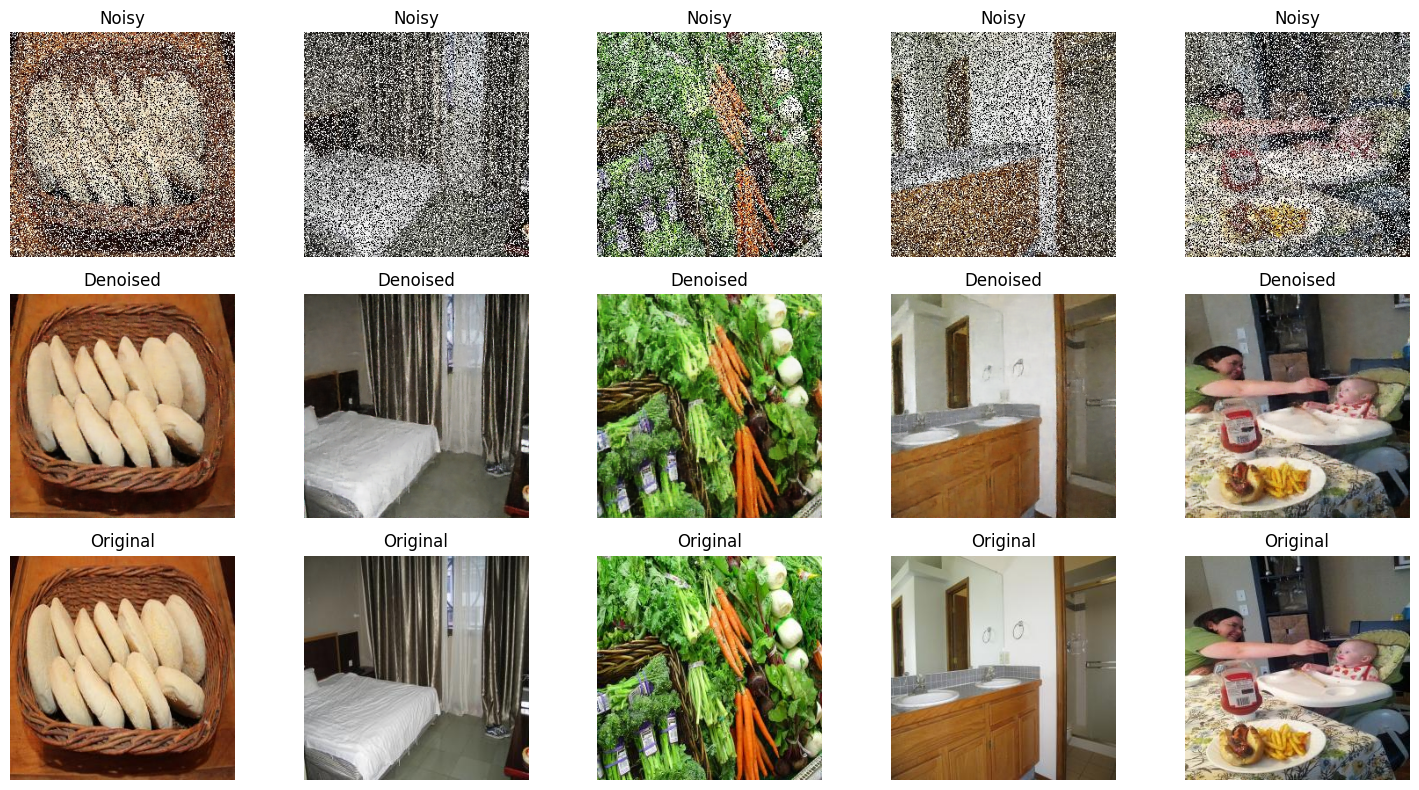

In [62]:
# %% [markdown]
# ## 8. Visualisation des Résultats
def plot_results(n=5):
    plt.figure(figsize=(15,8))
    predictions = model.predict(X_test[:n])
    for i in range(n):
        plt.subplot(3, n, i+1)
        plt.imshow(X_test[i])
        plt.title("Noisy")
        plt.axis('off')
        
        plt.subplot(3, n, i+1+n)
        plt.imshow(predictions[i])
        plt.title("Denoised")
        plt.axis('off')
        
        plt.subplot(3, n, i+1+2*n)
        plt.imshow(y_test[i])
        plt.title("Original")
        plt.axis('off')
    
    # Add padding between subplots
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    plt.tight_layout()
    plt.show()

plot_results()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


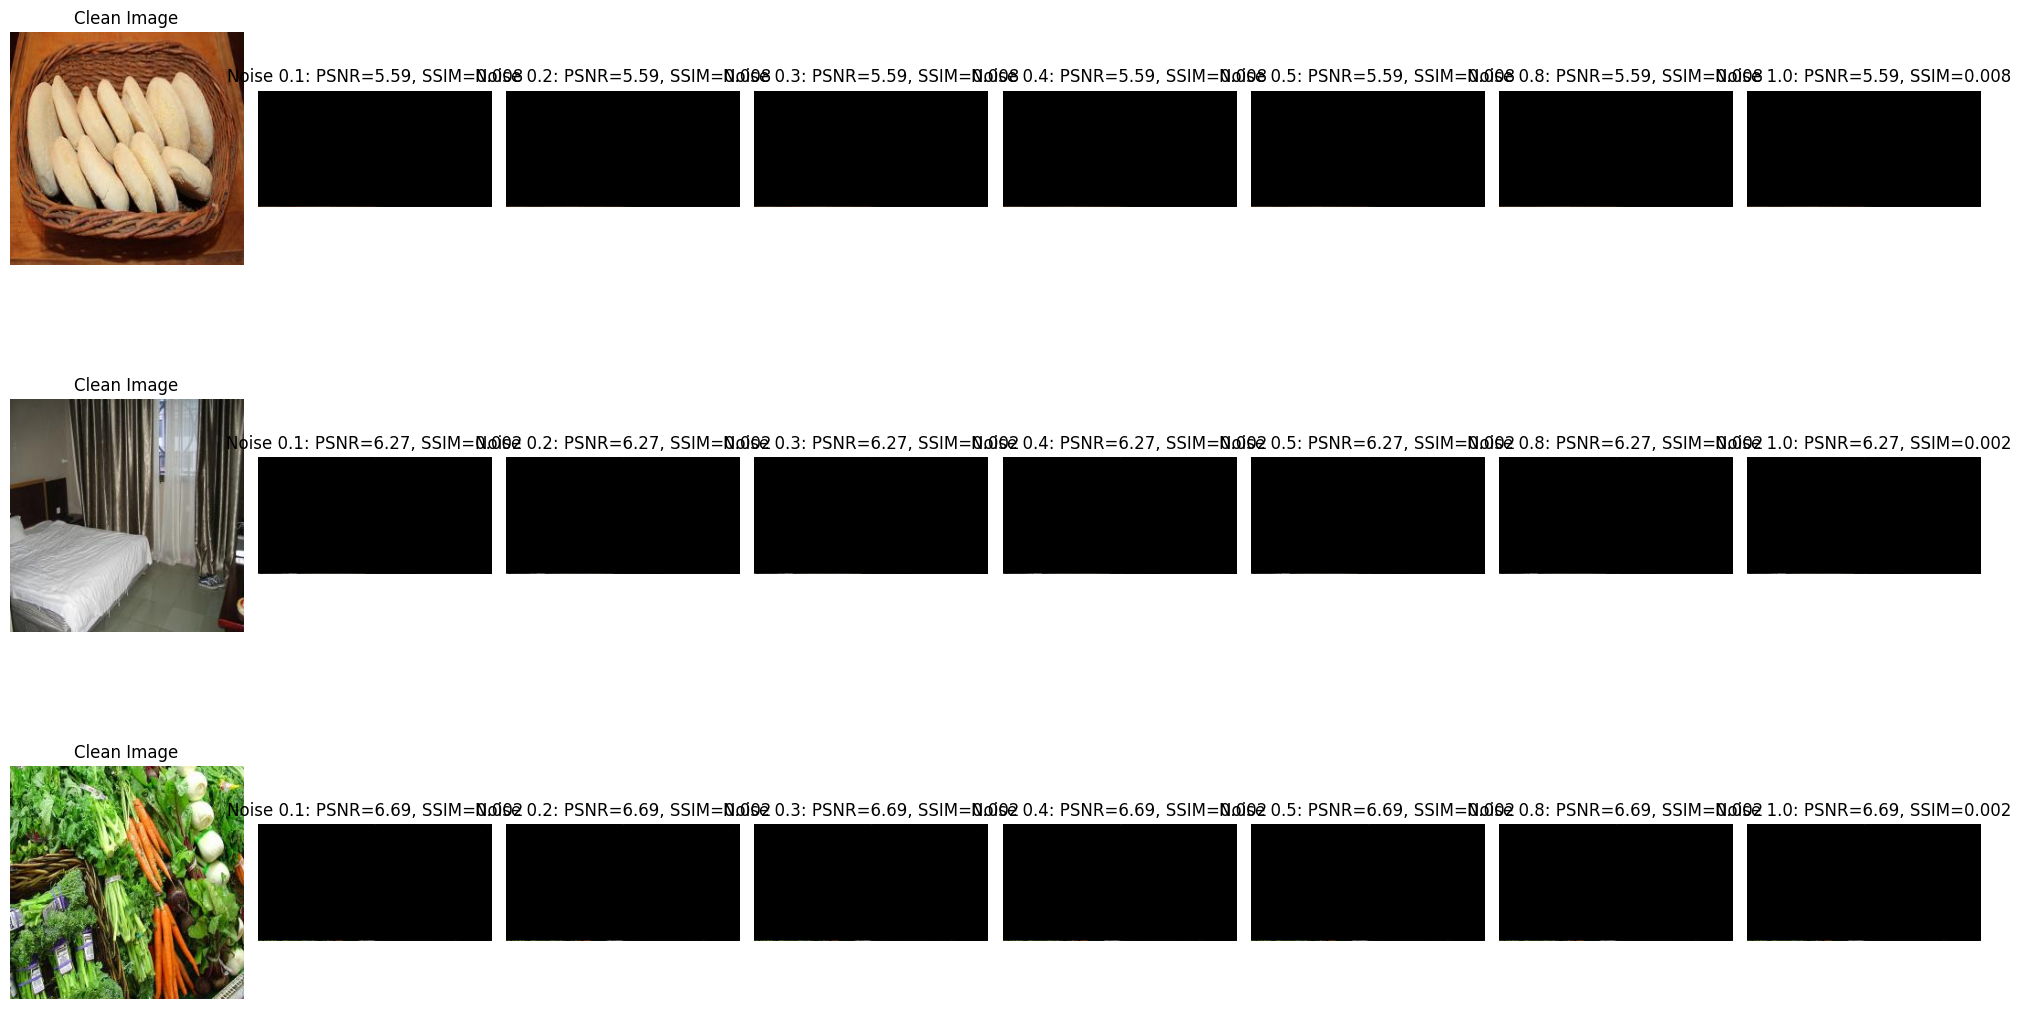

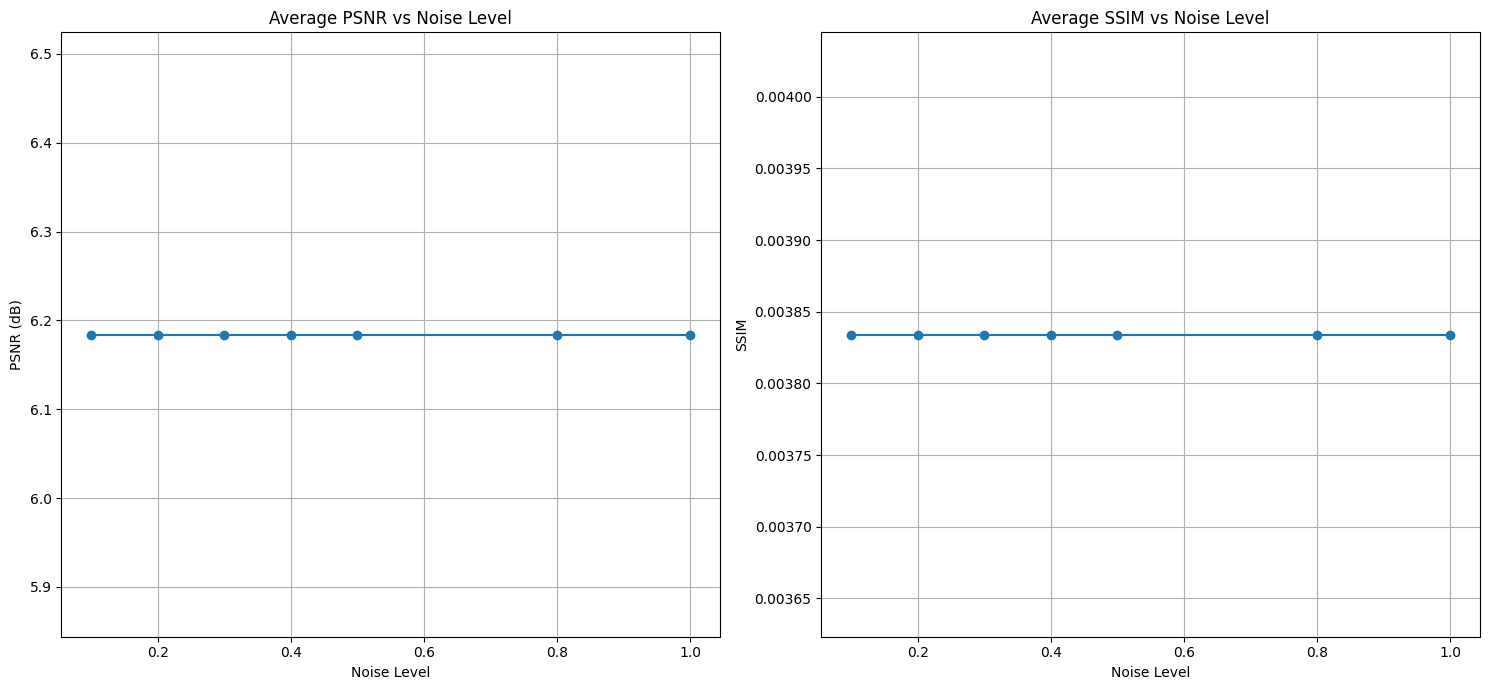

In [ ]:
## Try to predict on clean image with deiffenrent noise level from 0.1 to 1
def add_gaussian_noise(image, noise_level):
    """
    Add Gaussian noise to an image
    
    Args:
        image: Clean image (normalized to [0,1])
        noise_level: Standard deviation of the noise
    
    Returns:
        Noisy image clipped to [0,1] range
    """
    noise = np.random.normal(loc=0, scale=noise_level, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)  # Clip to valid range

# Select a few clean images from test set
num_samples = 3
selected_images = y_test[:num_samples]

# Define noise levels to test
noise_levels = [0.1,0.2,0.3,0.4,0.5,0.8,1.0]

# Create a figure for visualization
plt.figure(figsize=(20, 4*num_samples))

# Store metrics for each noise level
metrics = {level: {'psnr': [], 'ssim': []} for level in noise_levels}

for i, clean_img in enumerate(selected_images):
    # Show original clean image
    plt.subplot(num_samples, len(noise_levels) + 1, i*(len(noise_levels) + 1) + 1)
    plt.imshow(clean_img)
    plt.title("Clean Image")
    plt.axis('off')
    
    # Process each noise level
    for j, noise_level in enumerate(noise_levels):
        # Create noisy image
        noisy_img = add_gaussian_noise(clean_img, noise_level)
        
        # Predict (denoise)
        denoised_img = model.predict(np.expand_dims(noisy_img, axis=0))[0]
        
        # Calculate metrics
        psnr_val = psnr(clean_img, denoised_img)
        ssim_val = ssim(clean_img, denoised_img, channel_axis=-1, win_size=5, data_range=1.0)
        metrics[noise_level]['psnr'].append(psnr_val)
        metrics[noise_level]['ssim'].append(ssim_val)
        
        # Display noisy and denoised
        plt.subplot(num_samples, len(noise_levels) + 1, i*(len(noise_levels) + 1) + j + 2)
        
        # Create a side-by-side comparison
        comparison = np.hstack((noisy_img, denoised_img))
        plt.imshow(comparison)
        plt.title(f"Noise {noise_level}: PSNR={psnr_val:.2f}, SSIM={ssim_val:.3f}")
        plt.axis('off')

plt.tight_layout()
plt.show()

# Calculate average metrics for each noise level
avg_metrics = {level: {'psnr': np.mean(values['psnr']), 
                       'ssim': np.mean(values['ssim'])} 
              for level, values in metrics.items()}

# Plot average metrics vs noise level
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.plot(noise_levels, [avg_metrics[level]['psnr'] for level in noise_levels], 'o-')
plt.title('Average PSNR vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('PSNR (dB)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(noise_levels, [avg_metrics[level]['ssim'] for level in noise_levels], 'o-')
plt.title('Average SSIM vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('SSIM')
plt.grid(True)

plt.tight_layout()
plt.show()